# **Validação de insights através de Testes de Hipótese**

Notebook de apoio as análises de Churn na Vammo. Os insights podem ser encontrados no relatório.

Os testes estatísticos são realizados com o objetivo de comparar amostras dos grupos de ativos e churns para verificar se há diferenças significativas entre elas.

- Mann-Whitney *Teste não parametricos para dados que seguem distribuição não normal*. Colunas: L4W_ Avg Ridden KMs
- Student T para amostras idependentes: *Teste parametrico para dados que seguem distribuição normal*. Colunas: Age, Weekly Charged Price, L4w Additional Costs ($), Elapsed Time (Days)

Hipóteses:
- Hipótese Nula (H0): As distribuições das duas amostras são iguais.
- Hipótese Alternativa (H1): As distribuições das duas amostras são diferentes.
- Estatística do Teste: A estatística do teste
- Valor p: Indica a probabilidade de observar os dados, ou algo mais extremo, se a hipótese nula for verdadeira. Um valor p menor que o nível de significância (geralmente 0.05) leva à rejeição da hipótese nula.



**Importar bibliotecas**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from datetime import datetime
from scipy.stats import mannwhitneyu, ttest_ind, chi2_contingency
import os

**Importar Dados**

In [7]:
# Caminho para os arquivos do projeto

# Obtém o diretório atual
output_path = os.getcwd()

# Dirertorio de tabelas auxiliares
aux_file_path = os.path.join(output_path, 'tabelas_auxiliares') 

# Obtém o diretório atual
root_path = os.path.dirname(os.getcwd())

# Volta uma pasta no diretório atual
input_path = os.path.join(root_path, 'Dados') 

# Concatena o diretório com o arquivo de input
input_file_path = os.path.join(input_path, 'customers.xlsx') 

# Ler o arquivo Excel em um DataFrame
df_original = pd.read_excel(input_file_path)

# Mostrar o título das colunas e o tipo de cada coluna
df= df_original
print(df.dtypes)

Customer ID                          int64
Status                              object
Start Date                  datetime64[ns]
Ended At                    datetime64[ns]
Age                                float64
Weekly Charged Price                 int64
Extra Battery                        int64
L4w Additional Costs ($)           float64
L4W_ Avg Ridden KMs                float64
dtype: object


**Limpando os dados**

In [8]:
# Converter as colunas 'Start Date' e 'Ended At' para datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Ended At'] = pd.to_datetime(df['Ended At'], errors='coerce')

# Converter a coluna 'Customer ID' para string
df['Customer ID'] = df['Customer ID'].astype(str)
df['Extra Battery'] = df['Extra Battery'].astype(str)

# Criar coluna de tempo decorrido
df['Elapsed Time'] = df.apply(
    lambda row: (row['Ended At'] if pd.notnull(row['Ended At']) else datetime.now()) - row['Start Date'],
    axis=1
)
# Converter 'Elapsed Time' para quantidade de dias
df['Elapsed Time'] = df['Elapsed Time'].dt.days

df

,Customer ID,Status,Start Date,Ended At,Age,Weekly Charged Price,Extra Battery,L4w Additional Costs ($),L4W_ Avg Ridden KMs,Elapsed Time
0,23679,ACTIVE,2024-08-31,NaT,54.0,359,0,0.000,29.240000,24
1,23657,ACTIVE,2024-08-31,NaT,38.0,299,1,0.000,326.026000,24
2,23111,ACTIVE,2024-08-31,NaT,39.0,304,1,0.000,551.783167,24
3,23668,ACTIVE,2024-08-31,NaT,21.0,319,0,0.000,311.771500,24
4,23492,ACTIVE,2024-08-31,NaT,21.0,359,1,0.000,443.351500,24
...,...,...,...,...,...,...,...,...,...,...
594,1073,ACTIVE,2024-03-06,NaT,48.0,0,1,374.832,948.381125,202
595,19261,ACTIVE,2024-03-06,NaT,26.0,364,1,312.384,220.122375,202
596,19372,ACTIVE,2024-03-06,NaT,29.0,314,1,394.784,824.065437,202
597,19485,ACTIVE,2024-03-06,NaT,30.0,314,1,999.656,660.641250,202


**Plotar histogramas de dados numericos e classificar sua distribuição**


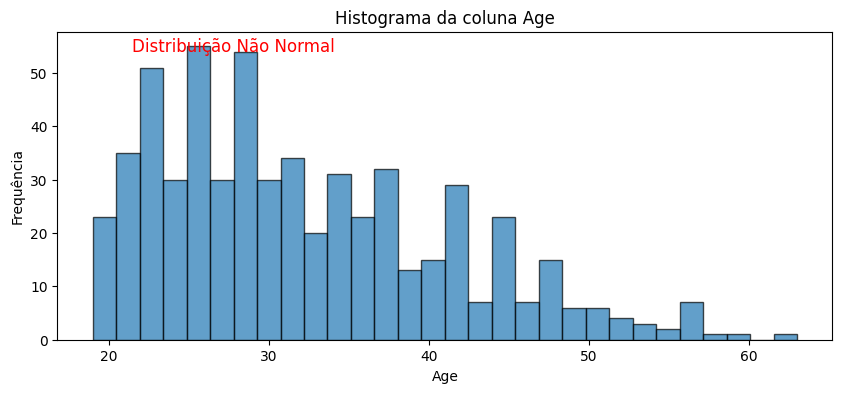

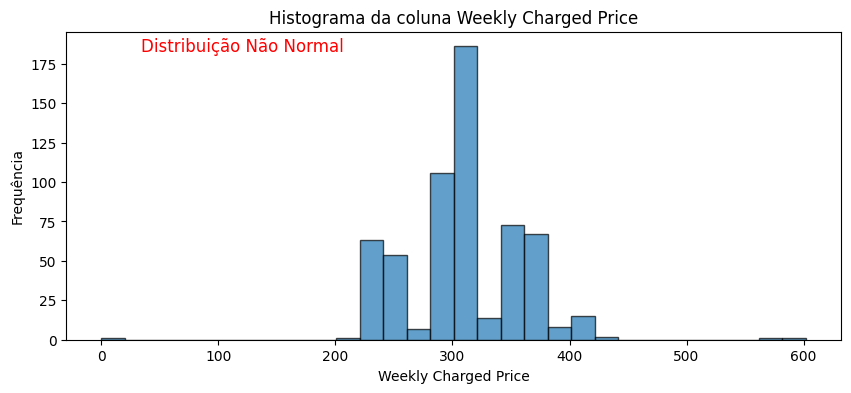

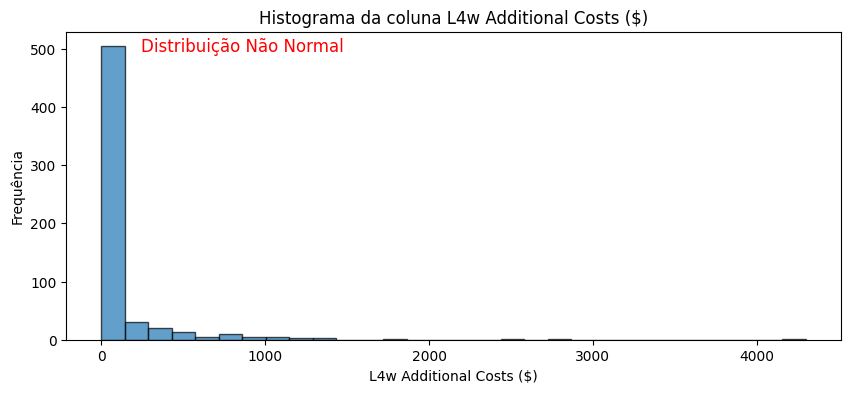

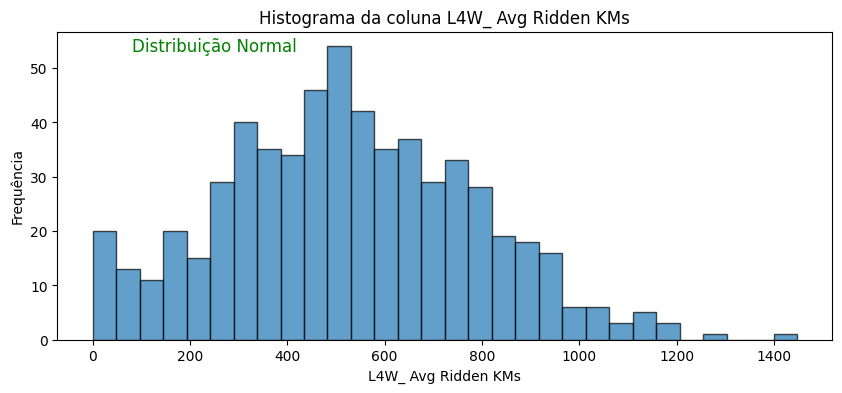

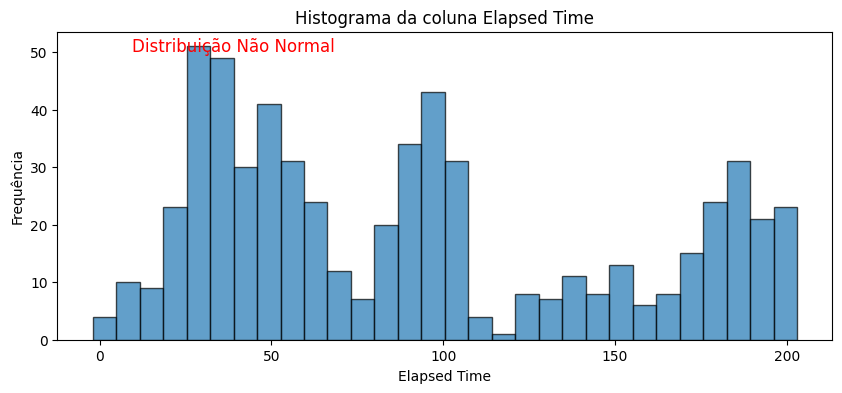

In [9]:
# Filtrar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns

# Plotar histogramas e classificar dados
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    plt.hist(df[col].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma da coluna {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    
    # Teste de normalidade
    stat, p = normaltest(df[col].dropna())
    alpha = 0.05
    if p > alpha:
        plt.figtext(0.20, 0.83, 'Distribuição Normal', fontsize=12, color='green')
    else:
        plt.figtext(0.20, 0.83, 'Distribuição Não Normal', fontsize=12, color='red')
    
    plt.show()

### **Teste estatísticos para entender o Churn**

In [10]:
# Função para realizar os testes estatísticos
def perform_tests(df, group_col, test_col, test_func, is_chi_square=False):
    groups = df[group_col].unique()
    if len(groups) != 2:
        raise ValueError("A coluna de grupo deve ter exatamente 2 grupos para realizar o teste estatístico.")
    
    group1 = df[df[group_col] == groups[0]][test_col].dropna()
    group2 = df[df[group_col] == groups[1]][test_col].dropna()
    
    if is_chi_square:
        contingency_table = pd.crosstab(df[group_col], df[test_col])
        stat, p, _, _ = test_func(contingency_table)
    else:
        stat, p = test_func(group1, group2)
    
    return stat, p, group1, group2, groups[0], groups[1]

# Definir os testes a serem realizados
tests = {
    'Age': (mannwhitneyu, False),
    'Weekly Charged Price': (mannwhitneyu, False),
    'L4w Additional Costs ($)': (mannwhitneyu, False),
    'L4W_ Avg Ridden KMs': (ttest_ind, False),
    'Elapsed Time': (mannwhitneyu, False),
    'Extra Battery': (chi2_contingency, True)
}

# Realizar os testes e armazenar os resultados
results = {}
for col, (test, is_chi_square) in tests.items():
    stat, p, group1, group2, group1_name, group2_name = perform_tests(df, 'Status', col, test, is_chi_square)
    results[col] = {'statistic': stat, 'p-value': p, 'group1': group1, 'group2': group2, 'group1_name': group1_name, 'group2_name': group2_name}

# Exibir os resultados
for col, result in results.items():
    print(f"Teste para {col}:")
    print(f"  Estatística: {result['statistic']}")
    print(f"  Valor p: {result['p-value']}")
    
    if result['p-value'] < 0.05:
        if col != 'Extra Battery':  # Medianas só fazem sentido para dados numéricos
            median1 = result['group1'].median()
            median2 = result['group2'].median()
            print(f"  Hipótese nula rejeitada. As amostras são diferentes.")
            print(f"  Mediana de {result['group1_name']}: {median1}")
            print(f"  Mediana de {result['group2_name']}: {median2}")
            if median1 > median2:
                print(f"  O grupo {result['group1_name']} tem uma mediana maior.")
            else:
                print(f"  O grupo {result['group2_name']} tem uma mediana maior.")
        else:
            print(f"  Hipótese nula rejeitada. As amostras são diferentes.")
    else:
        print(f"  Hipótese nula não rejeitada. As amostras não são significativamente diferentes.")
    print("\n")

Teste para Age:
  Estatística: 25459.0
  Valor p: 0.22588012425815462
  Hipótese nula não rejeitada. As amostras não são significativamente diferentes.


Teste para Weekly Charged Price:
  Estatística: 18850.5
  Valor p: 0.0003990953980376227
  Hipótese nula rejeitada. As amostras são diferentes.
  Mediana de ACTIVE: 304.0
  Mediana de CANCELED: 319.0
  O grupo CANCELED tem uma mediana maior.


Teste para L4w Additional Costs ($):
  Estatística: 26532.0
  Valor p: 0.0807778896525421
  Hipótese nula não rejeitada. As amostras não são significativamente diferentes.


Teste para L4W_ Avg Ridden KMs:
  Estatística: 4.4567390225392
  Valor p: 9.93987130439715e-06
  Hipótese nula rejeitada. As amostras são diferentes.
  Mediana de ACTIVE: 529.03840625
  Mediana de CANCELED: 389.12043750000004
  O grupo ACTIVE tem uma mediana maior.


Teste para Elapsed Time:
  Estatística: 34592.0
  Valor p: 5.1638748414960004e-11
  Hipótese nula rejeitada. As amostras são diferentes.
  Mediana de ACTIVE: 89

### **Avaliar as datas de início e fim de contrato para encontrar padrões e segmentações**

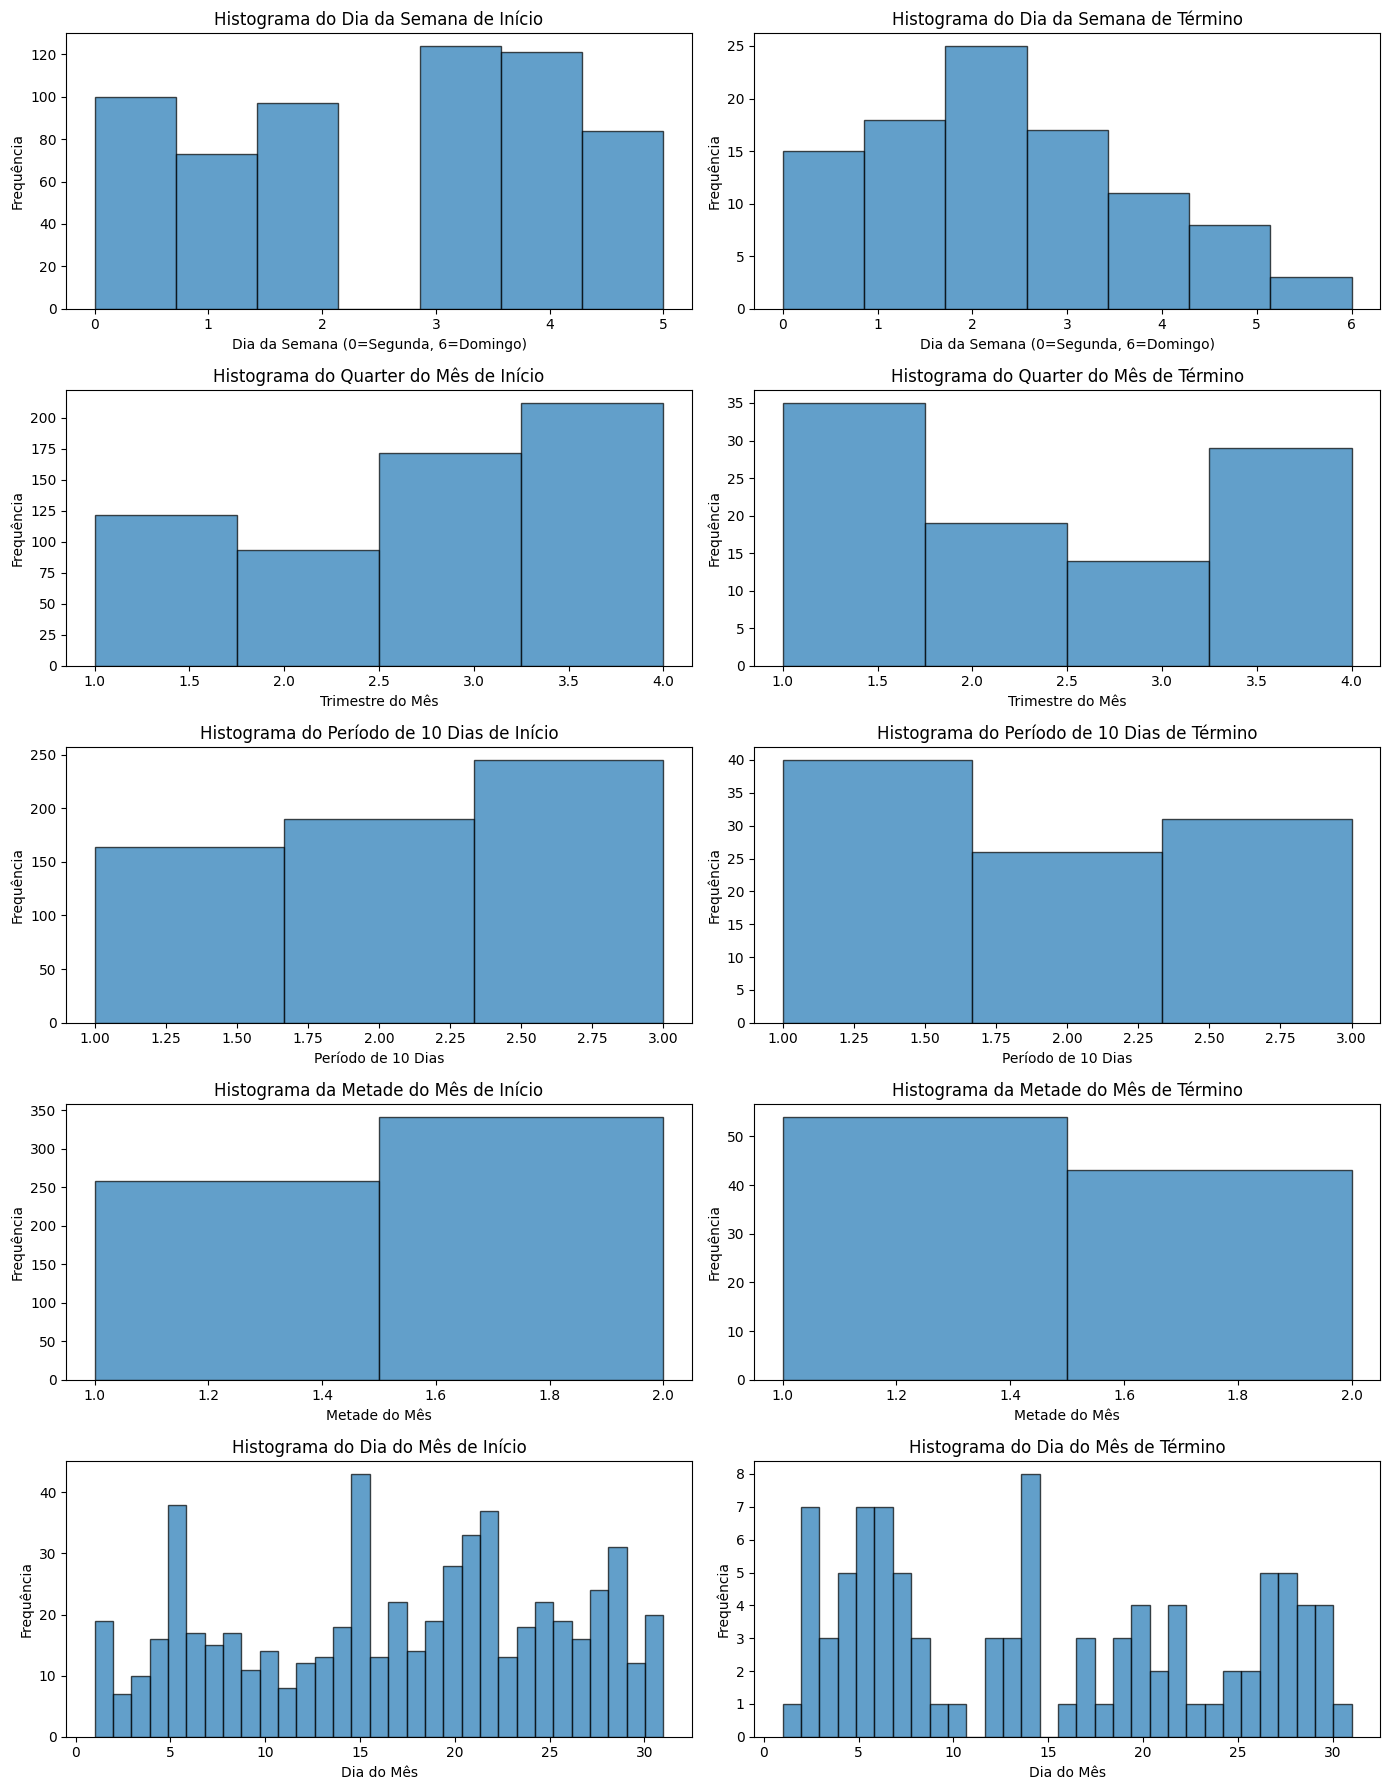

In [12]:
# Função para calcular o trimestre do mês
def quarter_of_month(dt):
    if pd.isna(dt):
        return None
    day = dt.day
    if day <= 7:
        return 1
    elif day <= 14:
        return 2
    elif day <= 21:
        return 3
    else:
        return 4

# Função para calcular o período de 10 dias no mês
def ten_day_period(dt):
    if pd.isna(dt):
        return None
    day = dt.day
    if day <= 10:
        return 1
    elif day <= 20:
        return 2
    else:
        return 3

# Função para calcular a metade do mês
def half_of_month(dt):
    if pd.isna(dt):
        return None
    day = dt.day
    if day <= 15:
        return 1
    else:
        return 2

# Extraindo o dia da semana, o trimestre do mês, o período de 10 dias, a metade do mês e o dia do mês
df['Start Day of Week'] = df['Start Date'].dt.dayofweek
df['Start Quarter of Month'] = df['Start Date'].apply(quarter_of_month)
df['Start Ten Day Period'] = df['Start Date'].apply(ten_day_period)
df['Start Half of Month'] = df['Start Date'].apply(half_of_month)
df['Start Day of Month'] = df['Start Date'].dt.day

df['End Day of Week'] = df['Ended At'].dt.dayofweek
df['End Quarter of Month'] = df['Ended At'].apply(quarter_of_month)
df['End Ten Day Period'] = df['Ended At'].apply(ten_day_period)
df['End Half of Month'] = df['Ended At'].apply(half_of_month)
df['End Day of Month'] = df['Ended At'].dt.day

# Plotando histogramas
fig, axes = plt.subplots(5, 2, figsize=(14, 18))

# Histograma para o dia da semana de início
axes[0, 0].hist(df['Start Day of Week'].dropna(), bins=7, edgecolor='k', alpha=0.7)
axes[0, 0].set_title('Histograma do Dia da Semana de Início')
axes[0, 0].set_xlabel('Dia da Semana (0=Segunda, 6=Domingo)')
axes[0, 0].set_ylabel('Frequência')

# Histograma para o dia da semana de término
axes[0, 1].hist(df['End Day of Week'].dropna(), bins=7, edgecolor='k', alpha=0.7)
axes[0, 1].set_title('Histograma do Dia da Semana de Término')
axes[0, 1].set_xlabel('Dia da Semana (0=Segunda, 6=Domingo)')
axes[0, 1].set_ylabel('Frequência')

# Histograma para o trimestre do mês de início
axes[1, 0].hist(df['Start Quarter of Month'].dropna(), bins=4, edgecolor='k', alpha=0.7)
axes[1, 0].set_title('Histograma do Quarter do Mês de Início')
axes[1, 0].set_xlabel('Trimestre do Mês')
axes[1, 0].set_ylabel('Frequência')

# Histograma para o trimestre do mês de término
axes[1, 1].hist(df['End Quarter of Month'].dropna(), bins=4, edgecolor='k', alpha=0.7)
axes[1, 1].set_title('Histograma do Quarter do Mês de Término')
axes[1, 1].set_xlabel('Trimestre do Mês')
axes[1, 1].set_ylabel('Frequência')

# Histograma para o período de 10 dias de início
axes[2, 0].hist(df['Start Ten Day Period'].dropna(), bins=3, edgecolor='k', alpha=0.7)
axes[2, 0].set_title('Histograma do Período de 10 Dias de Início')
axes[2, 0].set_xlabel('Período de 10 Dias')
axes[2, 0].set_ylabel('Frequência')

# Histograma para o período de 10 dias de término
axes[2, 1].hist(df['End Ten Day Period'].dropna(), bins=3, edgecolor='k', alpha=0.7)
axes[2, 1].set_title('Histograma do Período de 10 Dias de Término')
axes[2, 1].set_xlabel('Período de 10 Dias')
axes[2, 1].set_ylabel('Frequência')

# Histograma para a metade do mês de início
axes[3, 0].hist(df['Start Half of Month'].dropna(), bins=2, edgecolor='k', alpha=0.7)
axes[3, 0].set_title('Histograma da Metade do Mês de Início')
axes[3, 0].set_xlabel('Metade do Mês')
axes[3, 0].set_ylabel('Frequência')

# Histograma para a metade do mês de término
axes[3, 1].hist(df['End Half of Month'].dropna(), bins=2, edgecolor='k', alpha=0.7)
axes[3, 1].set_title('Histograma da Metade do Mês de Término')
axes[3, 1].set_xlabel('Metade do Mês')
axes[3, 1].set_ylabel('Frequência')

# Histograma para o dia do mês de início
axes[4, 0].hist(df['Start Day of Month'].dropna(), bins=31, edgecolor='k', alpha=0.7)
axes[4, 0].set_title('Histograma do Dia do Mês de Início')
axes[4, 0].set_xlabel('Dia do Mês')
axes[4, 0].set_ylabel('Frequência')

# Histograma para o dia do mês de término
axes[4, 1].hist(df['End Day of Month'].dropna(), bins=31, edgecolor='k', alpha=0.7)
axes[4, 1].set_title('Histograma do Dia do Mês de Término')
axes[4, 1].set_xlabel('Dia do Mês')
axes[4, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()